# Hierarchical Risk Parity Portfolios

In [1]:
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path

import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter

from datetime import datetime,timedelta
import yfinance as yf
plt.style.use("seaborn-v0_8-whitegrid")

# Path configuration (adjust base_dir if your CSV files live elsewhere)

In [16]:
base_dir = Path.cwd()
correlation_path = base_dir / "cormat.csv"
covariance_path = base_dir / "covmat.csv"

correlation_path, covariance_path

(WindowsPath('c:/my-git/DataScience-novaIMS/AssetPricingPortfolio/aulas/cormat.csv'),
 WindowsPath('c:/my-git/DataScience-novaIMS/AssetPricingPortfolio/aulas/covmat.csv'))

NR adaptation - based on real data

In [36]:
#stock_list = ["JPM","GE","MCD","WMT","BA", "GOOG", "NFLX", "AAPL", "AMZN", "META"]  # FAANG stocks

stock_list=['SPY','GLD','SLV','DBA','DBB','CPER','CANE','TLH','ISTB','EMB','ILF','INDA','MCHI','IEV','EWJ','EWA','USO','BWX','CBON','VGSH']

#stock_list=[
#    'AAPL', 'MSFT', 'AMZN', 'NVDA', 'GOOGL', 'TSLA', 'GOOG', 'BRK-B', 'UNH', 'XOM',
#    'META', 'JNJ', 'JPM', 'V', 'PG', 'AVGO', 'HD', 'CVX', 'MA', 'ABBV',
#    'PFE', 'BAC', 'KO', 'COST', 'WMT', 'DIS', 'TMO', 'MRK', 'ACN', 'ADBE',
#    'VZ', 'WFC', 'NFLX', 'ABT', 'CRM', 'NKE', 'CSCO', 'AMD', 'CMCSA', 'DHR',
#    'INTC', 'BMY', 'PM', 'TXN', 'LIN', 'QCOM', 'HON', 'UPS', 'NEE', 'RTX'
#]

to_date = datetime.now()  # today
from_date = to_date - timedelta(days=5*365)  # past five years
begin_date = from_date.strftime('%Y-%m-%d')
end_date = to_date.strftime('%Y-%m-%d')
interval = '1d'  #'1wk'  # weekly frequency

print(f"Downloading stock data for {stock_list} from {begin_date} to {end_date}...")

data = yf.download(
    tickers=stock_list,
    start=begin_date,
    end=end_date,
    interval=interval,
    group_by='ticker',
    auto_adjust=False,
    threads=True,
    progress=False
)

# Extract adjusted close prices
prices = data.xs('Adj Close', level=1, axis=1).copy()
cor_mat = prices.corr()
cov_mat = prices.cov()

cor_mat.shape, cov_mat.shape

((20, 20), (20, 20))

# Read Marcos Lopez de Prado (2016) paper data

In [31]:
cor_mat = pd.read_csv(correlation_path, header=None, sep=";", decimal=",", dtype=float)
cov_mat = pd.read_csv(covariance_path, header=None, sep=";", decimal=",", dtype=float)

cor_mat.shape, cov_mat.shape

((10, 10), (10, 10))

In [37]:
print(cor_mat)
print(cov_mat)

Ticker       BWX       SLV       IEV       USO       ILF      CANE       DBA  \
Ticker                                                                         
BWX     1.000000  0.000764 -0.184539 -0.863829 -0.417981 -0.725712 -0.580985   
SLV     0.000764  1.000000  0.864394  0.149453  0.583463  0.144125  0.711354   
IEV    -0.184539  0.864394  1.000000  0.350904  0.736652  0.437386  0.827925   
USO    -0.863829  0.149453  0.350904  1.000000  0.491507  0.667869  0.698794   
ILF    -0.417981  0.583463  0.736652  0.491507  1.000000  0.619791  0.669413   
CANE   -0.725712  0.144125  0.437386  0.667869  0.619791  1.000000  0.584359   
DBA    -0.580985  0.711354  0.827925  0.698794  0.669413  0.584359  1.000000   
CBON    0.334385  0.497839  0.537219  0.059104  0.127636 -0.129354  0.367291   
GLD    -0.270213  0.916843  0.888540  0.373650  0.631511  0.325318  0.873876   
SPY    -0.362755  0.825467  0.930752  0.508840  0.692178  0.489016  0.931009   
TLH     0.959570 -0.147812 -0.329169 -0.

# Hierarchical Clustering

[11  0 10  7 14 19 16 17  1 13 15  3  5  8  9  2 18  4  6 12]
['INDA', 'SPY', 'ILF', 'TLH', 'EWJ', 'VGSH', 'USO', 'BWX', 'GLD', 'IEV', 'EWA', 'DBA', 'CPER', 'ISTB', 'EMB', 'SLV', 'CBON', 'DBB', 'CANE', 'MCHI']


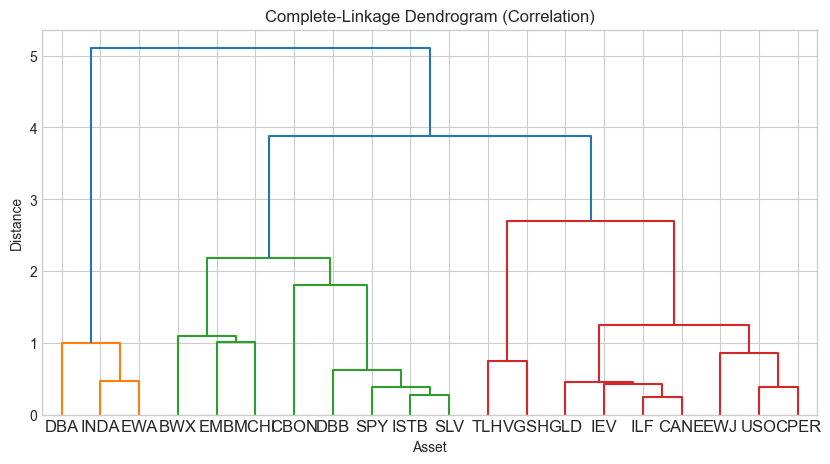

In [38]:
distance_cor = pdist(cor_mat.values, metric="euclidean")
linkage_single_cor = linkage(distance_cor, method="complete")  # single, complete, average, ward
cluster_order_cor = leaves_list(linkage_single_cor)
# Display cluster order using symbol names instead of ordinal indices
cluster_order_names = [stock_list[i] for i in cluster_order_cor]
print( cluster_order_cor )
print( cluster_order_names )

plt.figure(figsize=(10, 5))
dendrogram(linkage_single_cor, color_threshold=None, labels=cluster_order_names)
plt.title("Complete-Linkage Dendrogram (Correlation)")
plt.xlabel("Asset")
plt.ylabel("Distance")
plt.show()

Single-Linkage Covariance

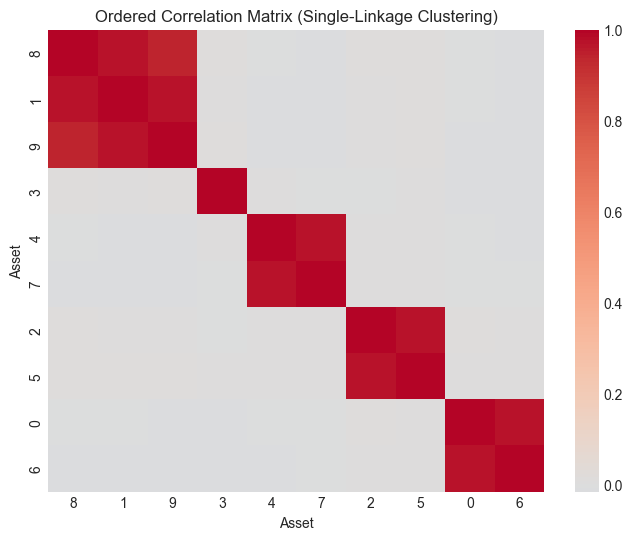

In [21]:
ordered_corr = cor_mat.iloc[cluster_order_cor, cluster_order_cor]
plt.figure(figsize=(8, 6))
sns.heatmap(ordered_corr, cmap="coolwarm", center=0, annot=False)
plt.title("Ordered Correlation Matrix (Single-Linkage Clustering)")
plt.xlabel("Asset")
plt.ylabel("Asset")
plt.show()

# Helper functions (Inverse-Variance, cluster variance, recursive bisection)

In [22]:
def get_inverse_variance_weights(covariance: np.ndarray) -> np.ndarray:
    """Compute inverse-variance portfolio weights."""
    variances = np.diag(covariance)
    inv_variances = 1.0 / variances
    weights = inv_variances / inv_variances.sum()
    return weights


def get_cluster_variance(covariance: pd.DataFrame, cluster_indices: np.ndarray) -> float:
    """Compute variance of a cluster using IVP weights."""
    sub_cov = covariance.iloc[cluster_indices, cluster_indices].to_numpy()
    weights = get_inverse_variance_weights(sub_cov)
    return float(weights.T @ sub_cov @ weights)


def recursive_bisection(covariance: pd.DataFrame, ordered_indices: np.ndarray) -> np.ndarray:
    """Apply López de Prado's recursive bisection to obtain HRP weights."""
    weights = np.ones(len(covariance))

    def _split(index_subset: np.ndarray) -> None:
        if len(index_subset) <= 1:
            return

        split_point = len(index_subset) // 2
        left = index_subset[:split_point]
        right = index_subset[split_point:]

        var_left = get_cluster_variance(covariance, left)
        var_right = get_cluster_variance(covariance, right)
        allocation = 1.0 - var_left / (var_left + var_right)

        weights[left] *= allocation
        weights[right] *= (1.0 - allocation)

        _split(left)
        _split(right)

    _split(ordered_indices)
    normalized = weights / weights.sum()
    return normalized

# Hierarchical Risk Parity Portfolio (HRPP) vs Inverse-Variance Portfolio (IVP)

In [23]:
hrp_weights = recursive_bisection(cor_mat, cluster_order_cor)
ivp_weights = get_inverse_variance_weights(cor_mat.to_numpy())

weights_df = pd.DataFrame({
    "Asset": [stock_list[i] for i in cluster_order_cor],
    "HRP": hrp_weights,
    "IVP": ivp_weights
})
weights_df

,Asset,HRP,IVP
0,ISTB,0.065561,0.1
1,GLD,0.057480,0.1
2,EMB,0.143336,0.1
3,DBA,0.112481,0.1
4,DBB,0.112481,0.1
5,TLH,0.129160,0.1
6,SLV,0.065561,0.1
7,CPER,0.143336,0.1
8,SPY,0.057480,0.1
9,CANE,0.113123,0.1


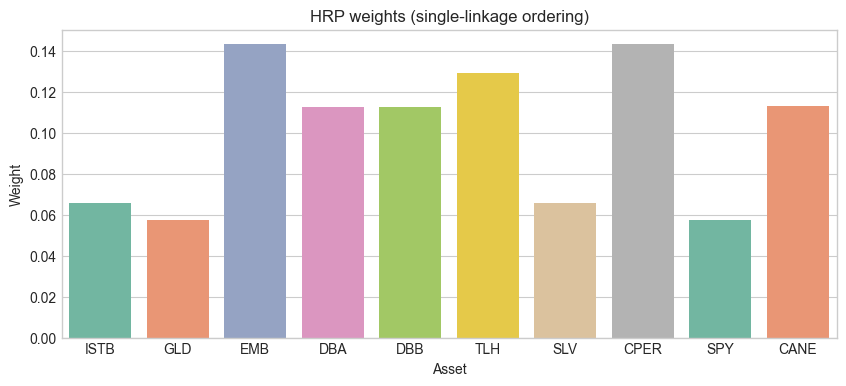

In [24]:
plt.figure(figsize=(10, 4))
sns.barplot(x=weights_df["Asset"], y=weights_df["HRP"], palette="Set2")
plt.title("HRP weights (single-linkage ordering)")
plt.xlabel("Asset")
plt.ylabel("Weight")
plt.show()

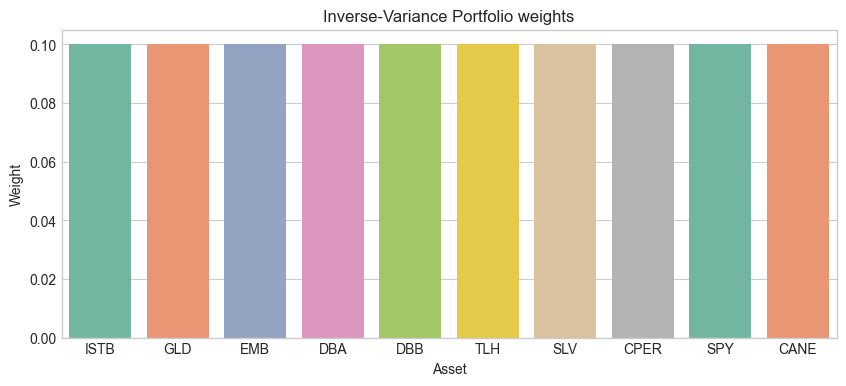

In [25]:
plt.figure(figsize=(10, 4))
sns.barplot(x=weights_df["Asset"], y=weights_df["IVP"], palette="Set2")
plt.title("Inverse-Variance Portfolio weights")
plt.xlabel("Asset")
plt.ylabel("Weight")
plt.show()

# Hierarchical Risk Parity using different linkage methods

In [41]:
def hrp_for_linkage(covariance: pd.DataFrame, method: str) -> np.ndarray:
    distance = pdist(covariance.values, metric="euclidean")
    linkage_matrix = linkage(distance, method=method)
    ordering = leaves_list(linkage_matrix)
    return recursive_bisection(covariance, ordering)

linkage_methods = ["single", "complete", "average", "ward"]

weights_by_method = {
    method: hrp_for_linkage(cor_mat, method)
    for method in linkage_methods
}

weights_table = pd.DataFrame(
    weights_by_method,
    index=pd.Index(stock_list, name="Asset")
)
weights_table

,single,complete,average,ward
Asset,,,,
SPY,0.039500,0.064855,0.038399,0.038279
GLD,0.024776,0.026445,0.029444,0.028540
SLV,0.012933,0.040662,0.014653,0.016233
DBA,0.165589,0.069145,0.160971,0.160471
DBB,0.017244,0.045902,0.020105,0.010232
CPER,0.165589,0.049579,0.160971,0.160471
CANE,0.015429,0.024589,0.020105,0.034930
TLH,0.024257,0.059538,0.020470,0.036822
ISTB,0.024934,0.026038,0.028250,0.017315


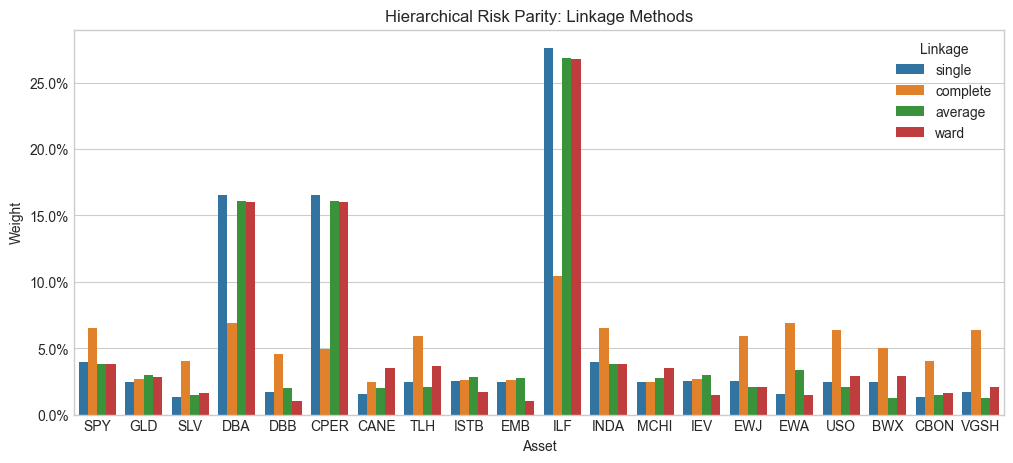

In [42]:
df_plot = (
    weights_table
    .reset_index()
    .melt(id_vars="Asset", var_name="Linkage", value_name="Weight")
)

plt.figure(figsize=(12, 5))
sns.barplot(data=df_plot, x="Asset", y="Weight", hue="Linkage")
plt.title("Hierarchical Risk Parity: Linkage Methods")
plt.xlabel("Asset")
plt.ylabel("Weight")
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1))
plt.legend(title="Linkage")
plt.show()